In [1]:
! pip install kaggle

In [2]:
! pip install kagglehub

In [3]:
! pip install numpy
! pip install pandas
! pip install matplotlib

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from pandas.plotting import scatter_matrix

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\MVideo\.cache\kagglehub\datasets\ahmeduzaki\global-earthquake-tsunami-risk-assessment-dataset\versions\1


In [7]:
df = pd.read_csv(f"{path}/earthquake_data_tsunami.csv")

In [8]:
df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


Добавим в базу данных атрибут "energy", в котором будет записана энергию землетрясения в джоулях по формуле $E = 10^{(1,5*M + 4,8)}$, где M - магнитуда колебаний

In [9]:
df['energy'] = 10**(1.5*df['magnitude']+4.8)

In [10]:
df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,energy
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1,1.995262e+15
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0,1.412538e+15
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1,1.995262e+15
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1,5.623413e+15
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1,5.011872e+14


Атрибут "energy" успешно добавлен

Причесываем датасет
Сначала проверим дубликаты

In [11]:
duplicates = df.duplicated(subset=['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami', 'energy'], keep=False)
print(f"Найдено потенциальных дубликатов: {duplicates.sum()}")

Найдено потенциальных дубликатов: 0


Проверим на кривые данные. 
magnitude, cdi, mmi, sig, nst, dmin, gap, depth, energy должны быть больше или равны 0.
latitude, longitude должны быть между -180 и 180
Month должен быть между 1 и 12
Year должен быть между 1 и 2025

In [12]:
wrong=df[(df['magnitude'] <0) | (df['cdi'] <0) | (df['mmi'] <0) | (df['sig'] <0) | (df['nst'] <0) | (df['dmin'] <0) | (df['gap'] <0) | (df['depth'] <0) | (df['energy'] <0) | (df['latitude'] >180) | (df['latitude'] <-180) | (df['longitude'] <-180) | (df['longitude'] >180) | (df['Month'] <1) | (df['Month'] >12) | (df['Year'] <1) | (df['Year'] >2025)]
print("Найдено", len(wrong), "кривых данных")

Найдено 0 кривых данных


Теперь найдем выбросы используя метод межквартильного размаха и отсечем их

In [13]:
df_clear=df

In [14]:
for attribute in df.columns:
    if attribute=='tsunami':
        continue
    df_p=df_clear
    q1 = df_p[attribute].quantile(0.25)
    q3 = df_p[attribute].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_clear = df_p[(df_p[attribute] >= lower_bound) & (df_p[attribute] <= upper_bound)]
df_clear = df_clear.copy()

In [15]:
print(f"Количество строк изначального датасета: {len(df)}")

Количество строк изначального датасета: 782


In [16]:
print(f"Количество строк измененного датасета: {len(df_clear)}")

Количество строк измененного датасета: 395


Таким образом убрав выбросы, датасет стал значительно меньше

Теперь построим графики зависимости и изучим их

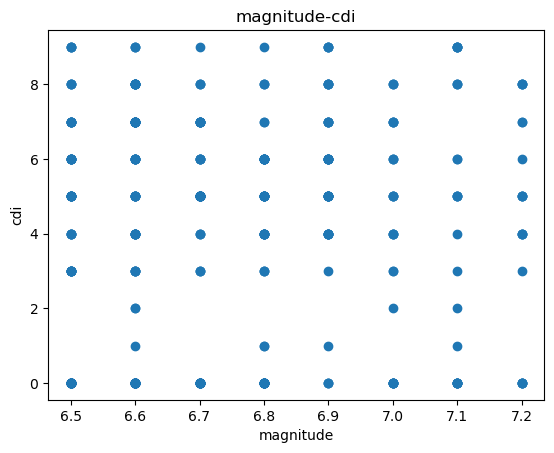

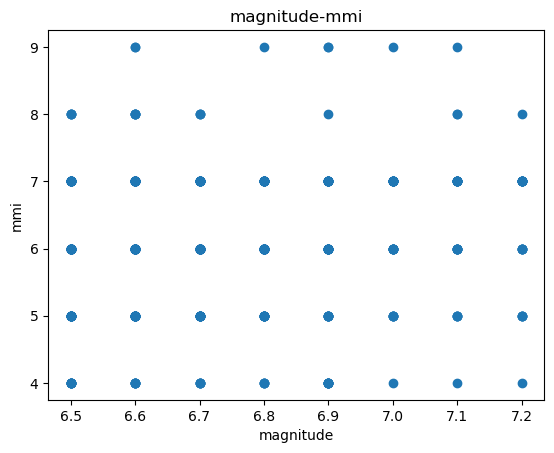

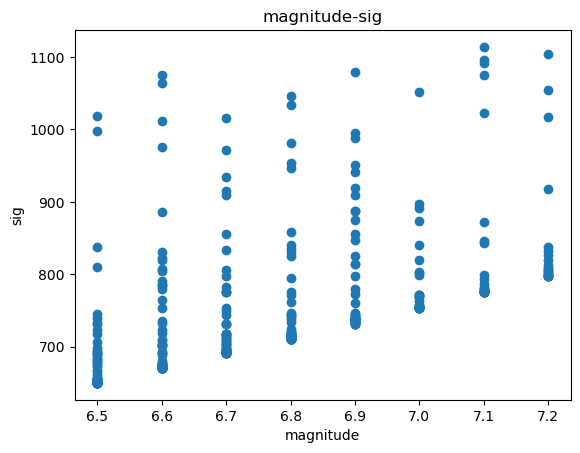

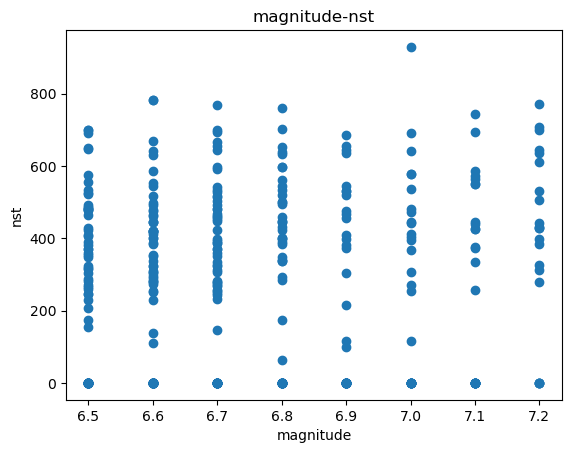

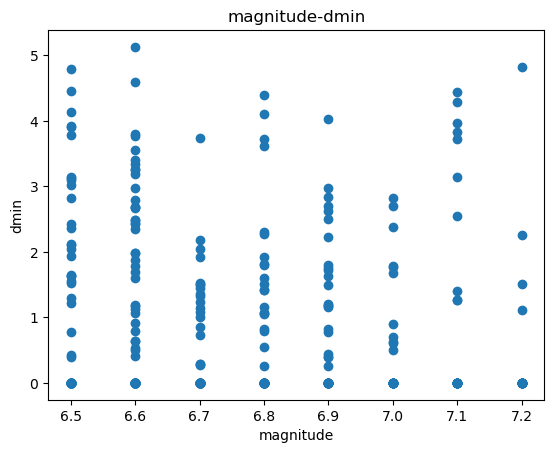

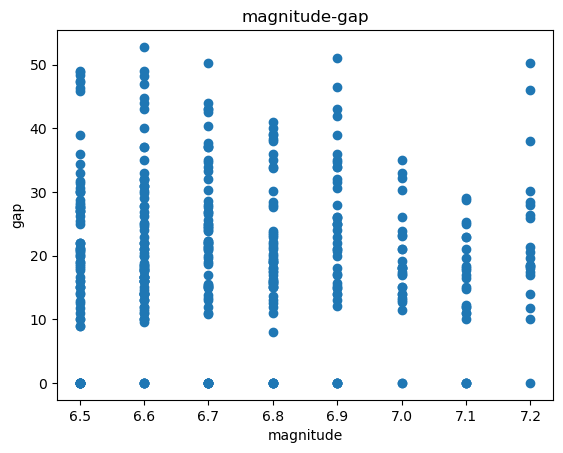

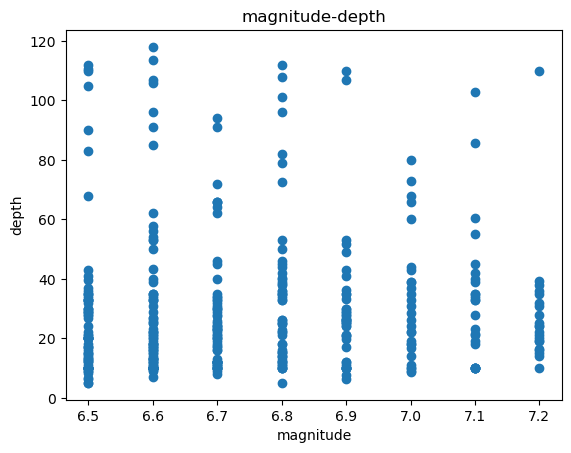

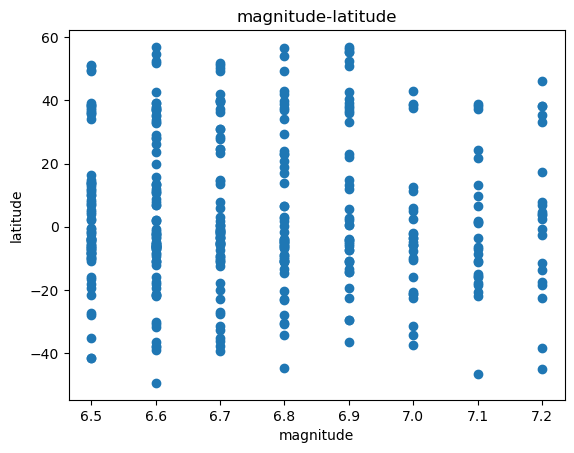

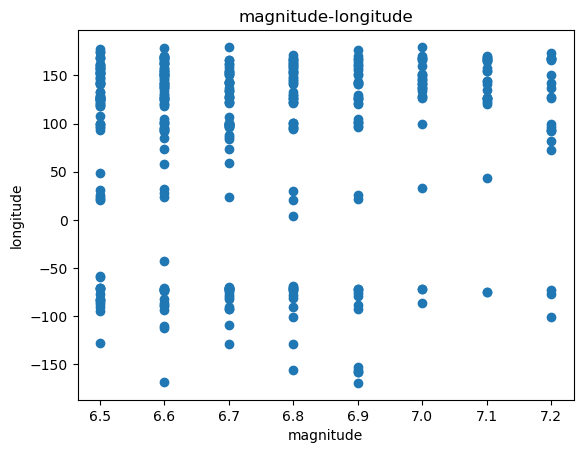

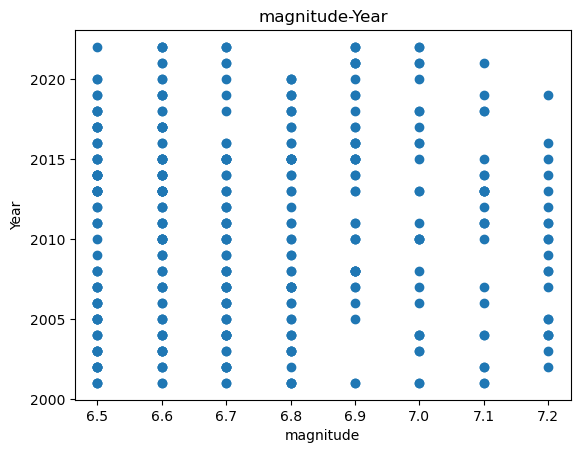

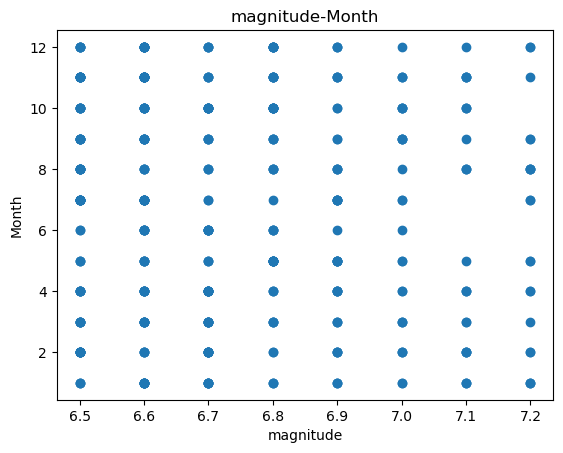

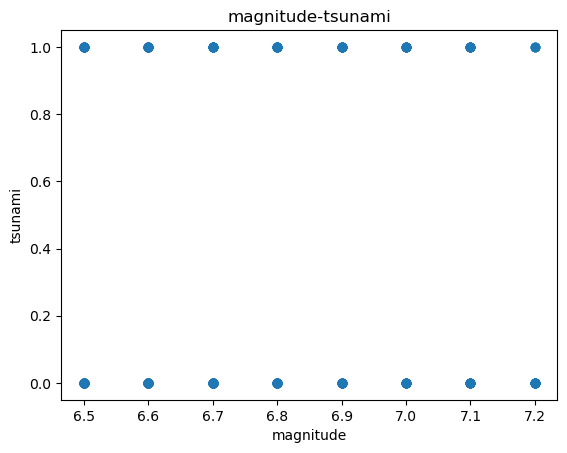

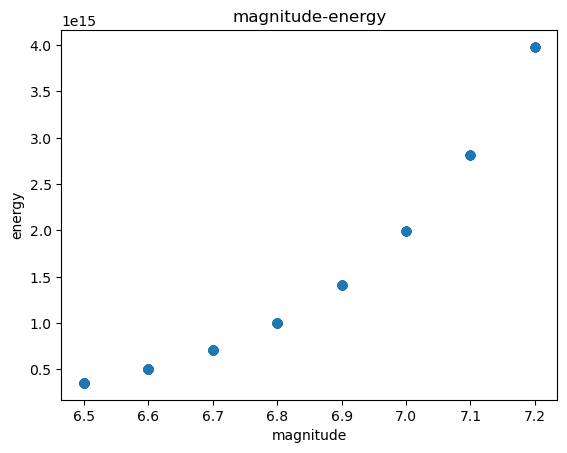

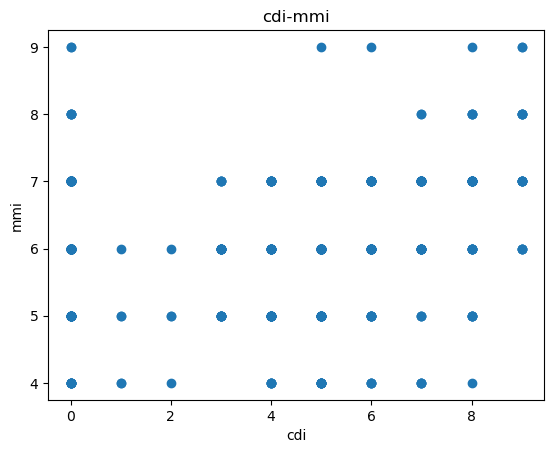

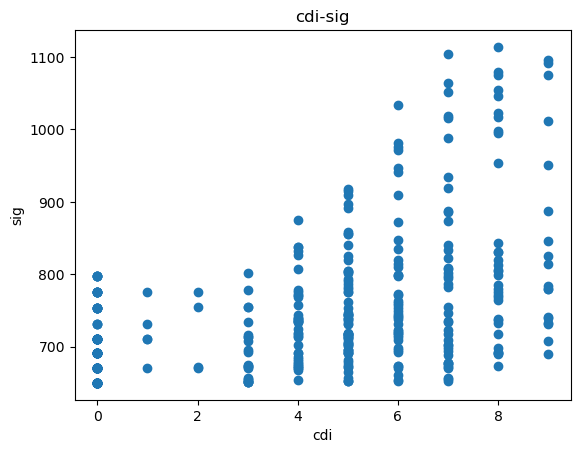

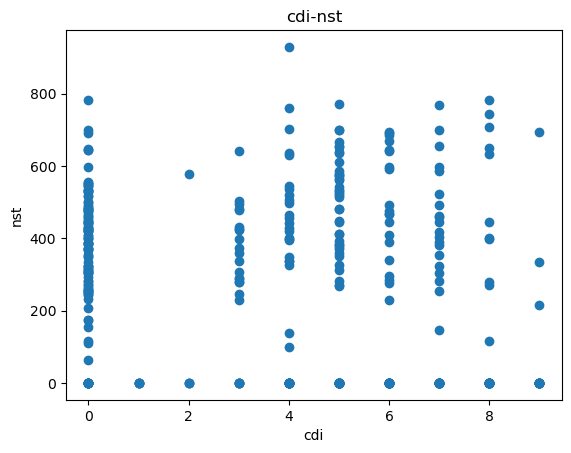

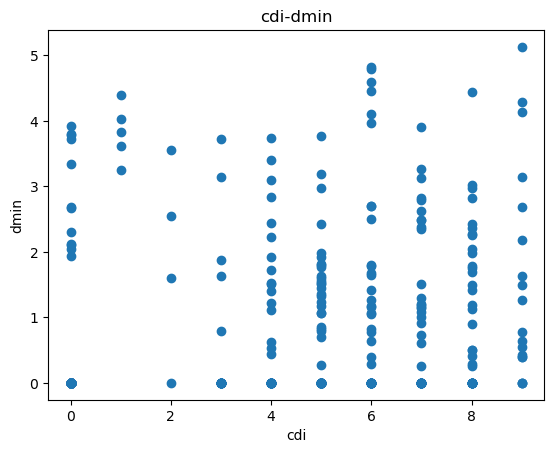

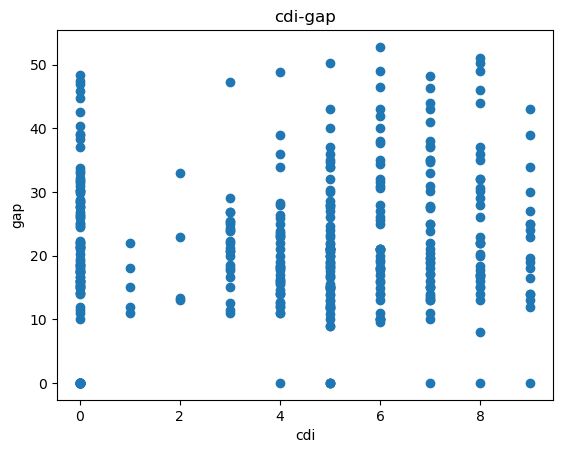

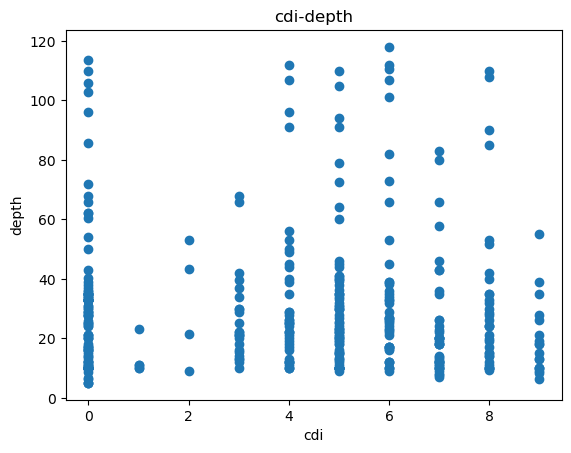

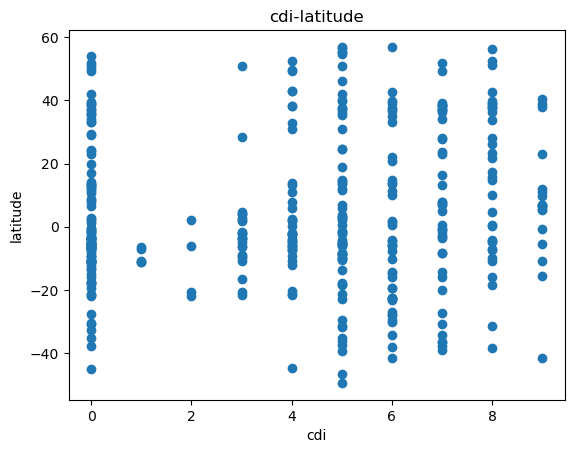

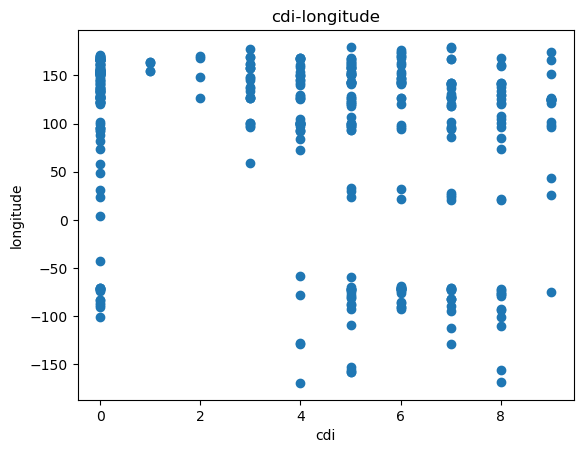

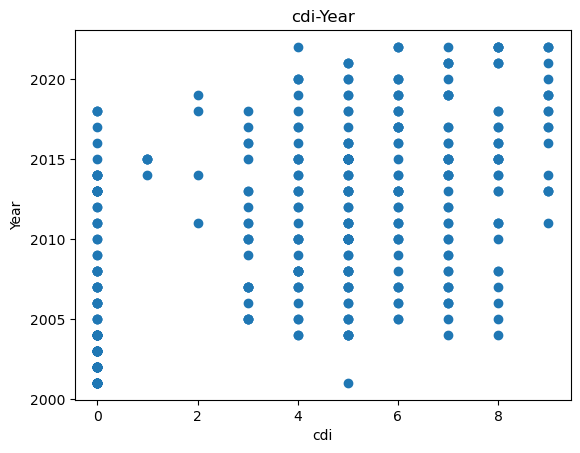

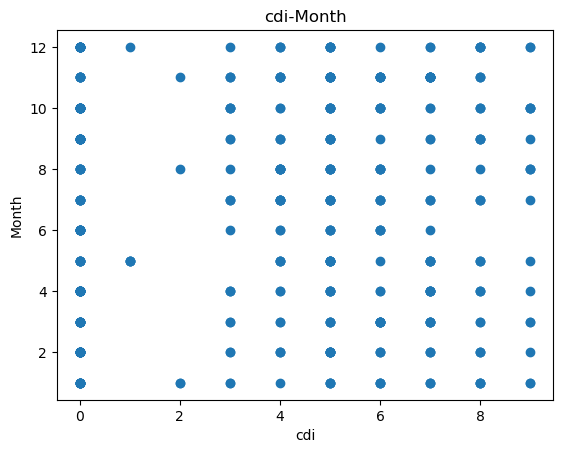

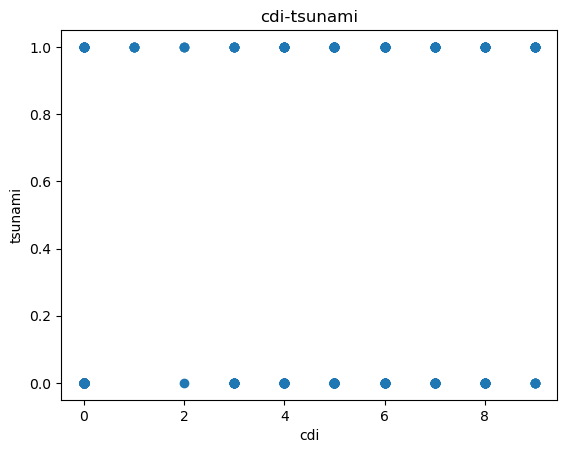

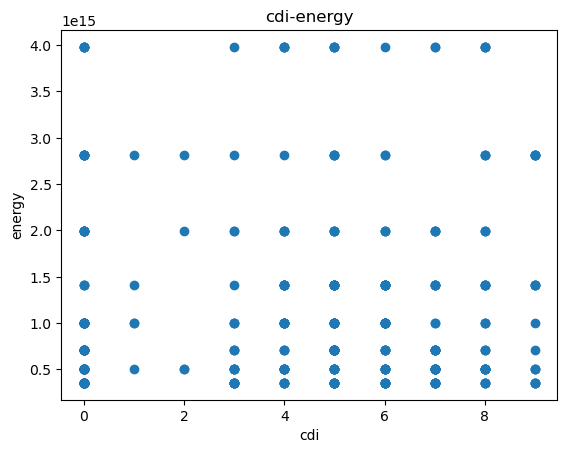

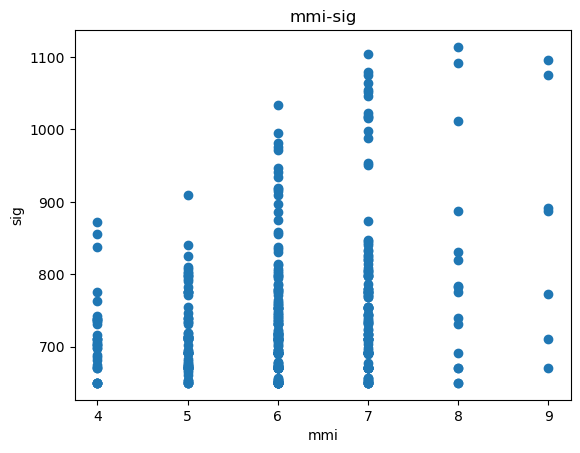

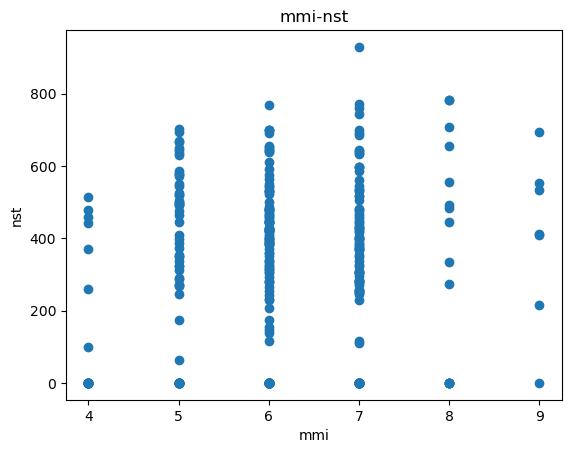

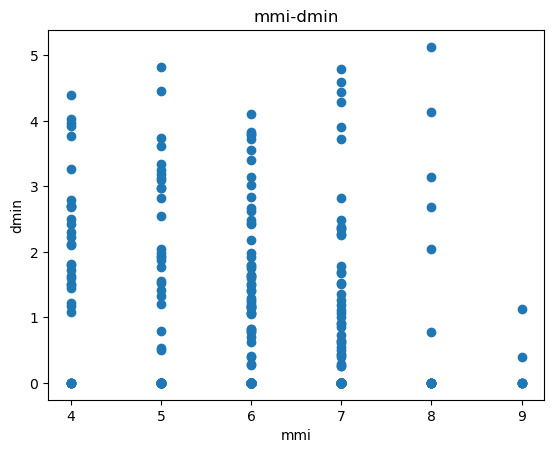

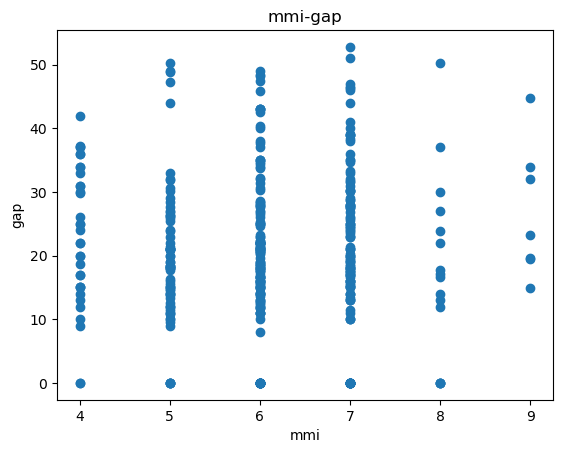

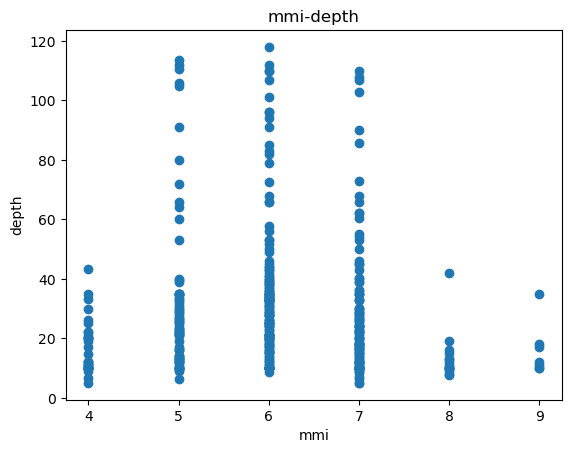

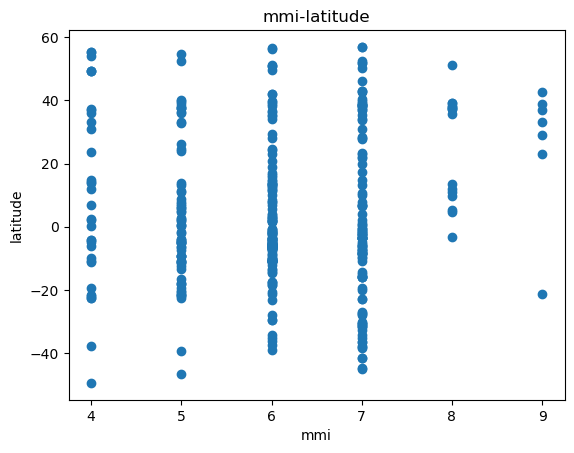

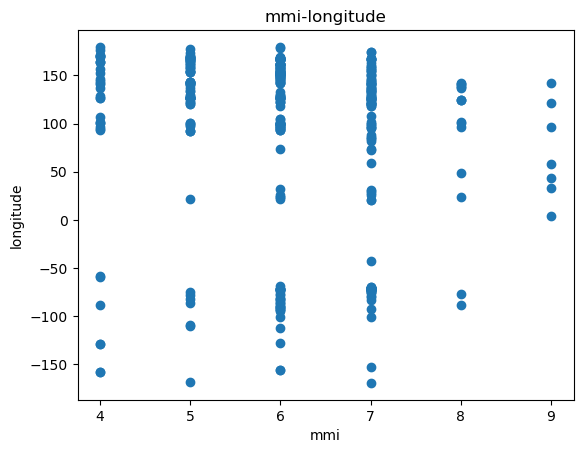

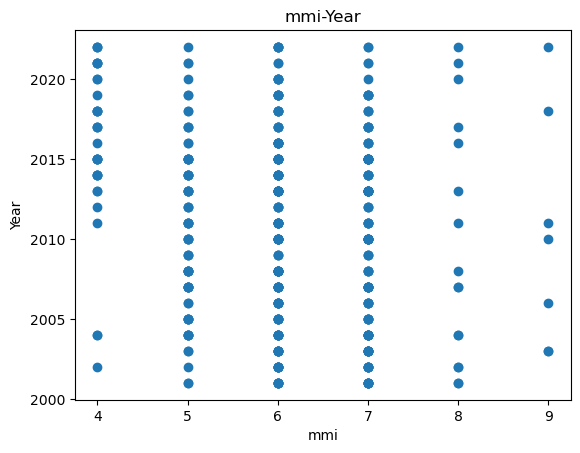

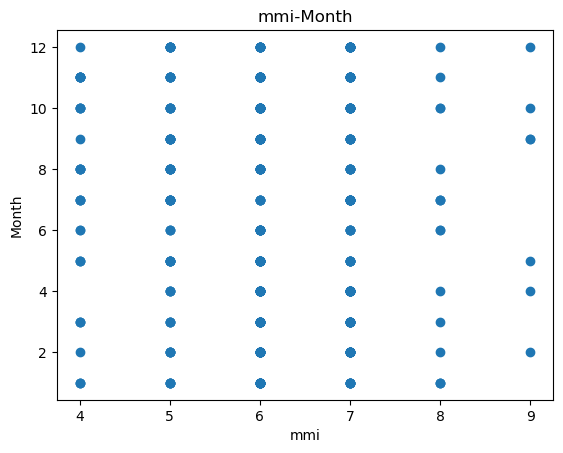

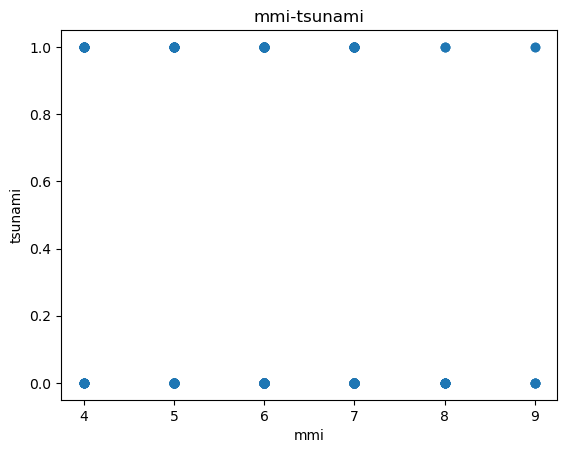

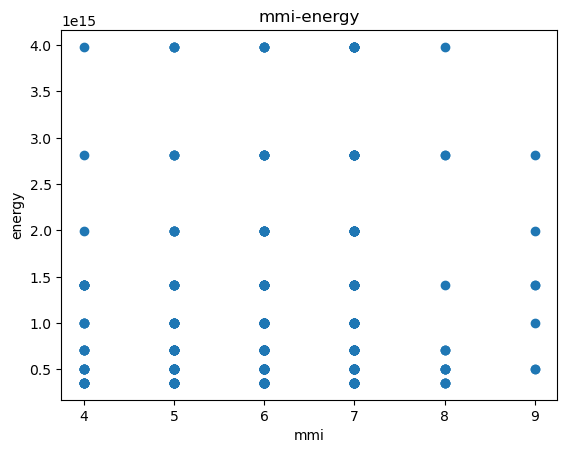

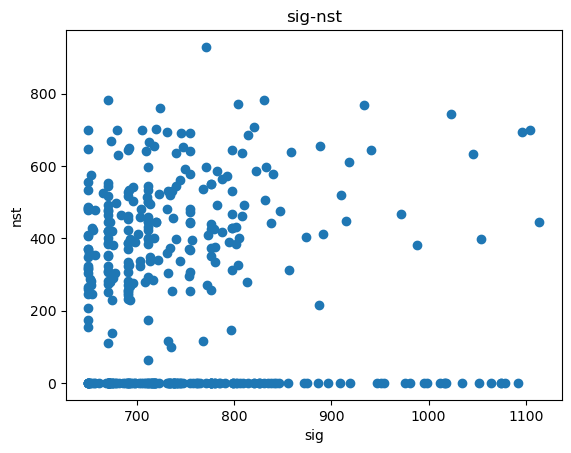

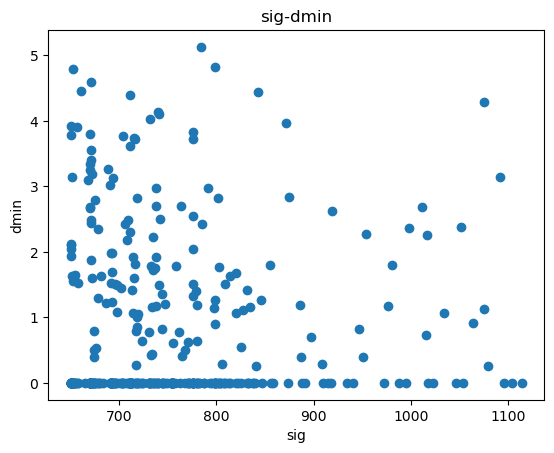

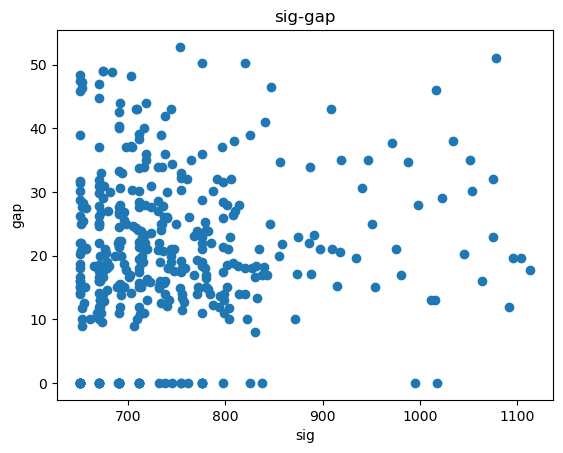

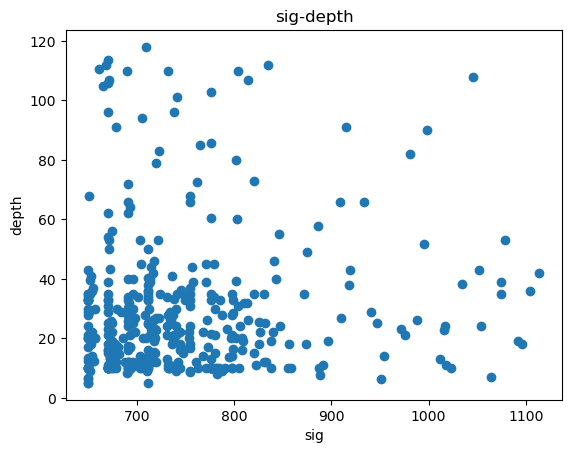

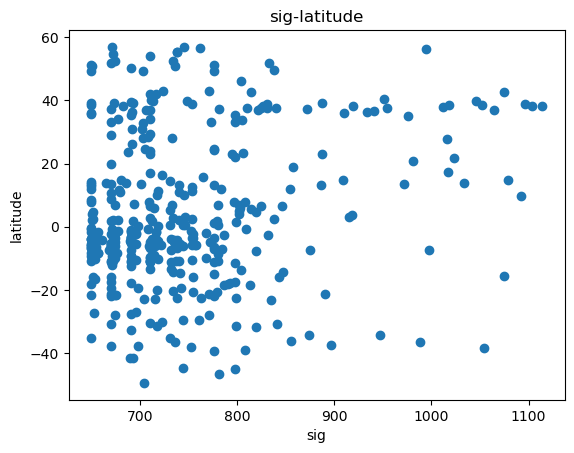

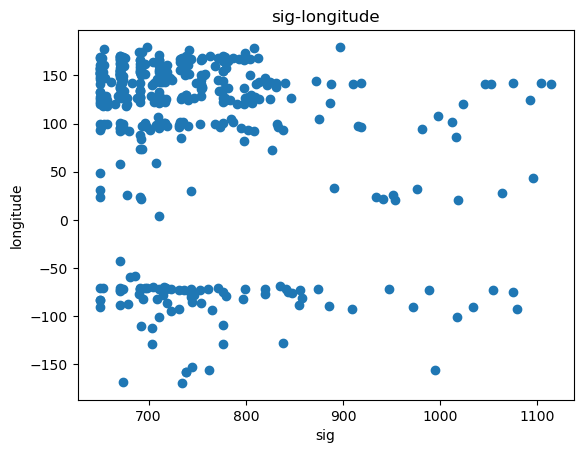

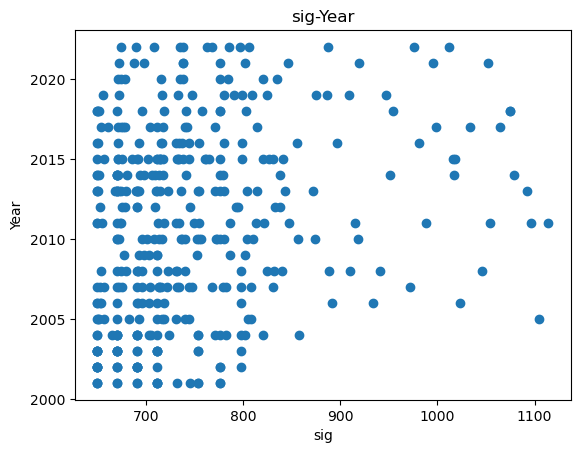

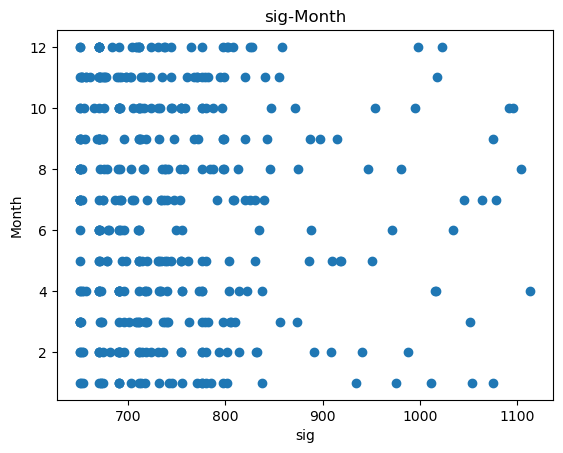

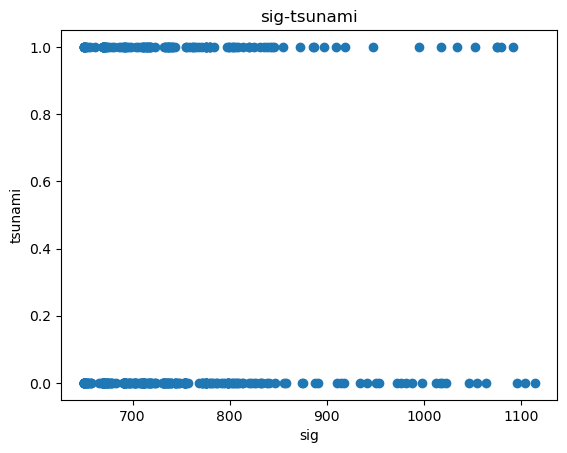

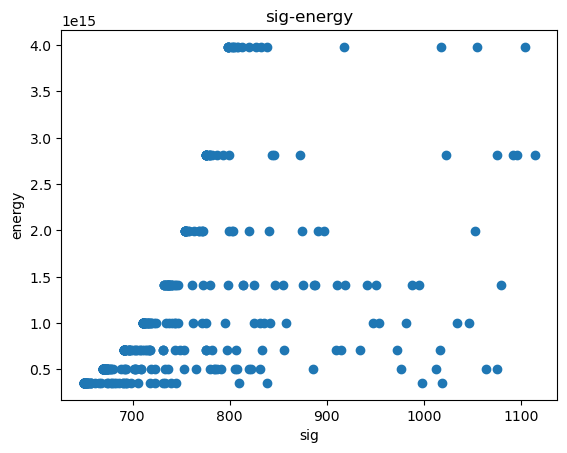

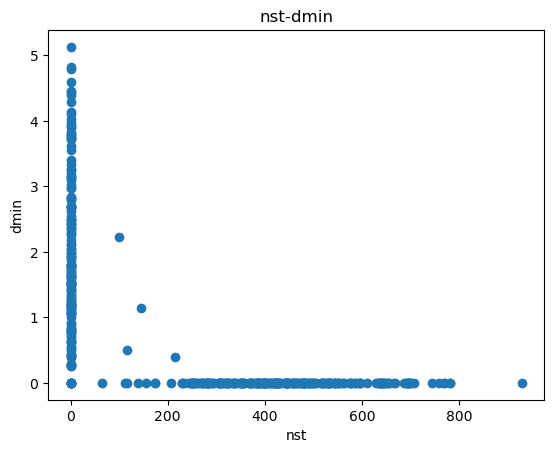

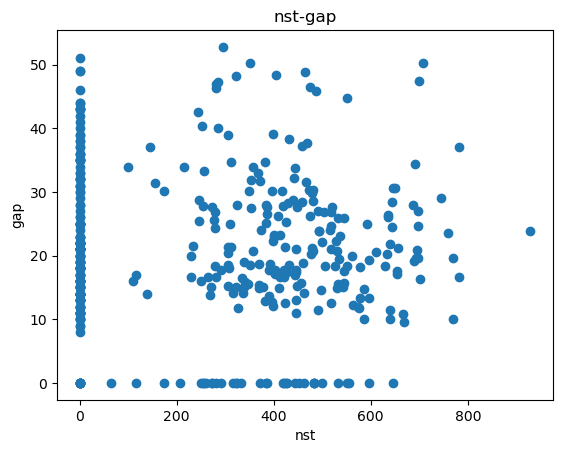

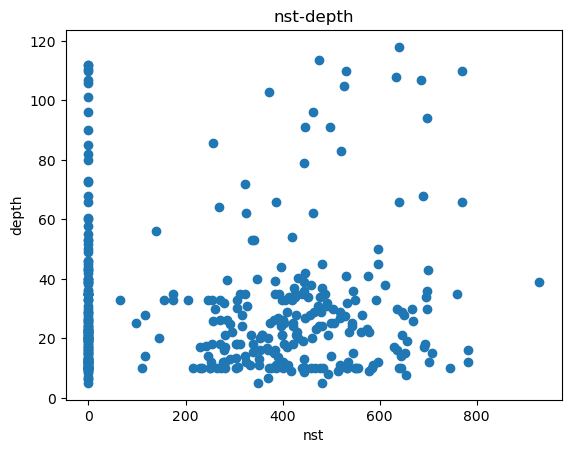

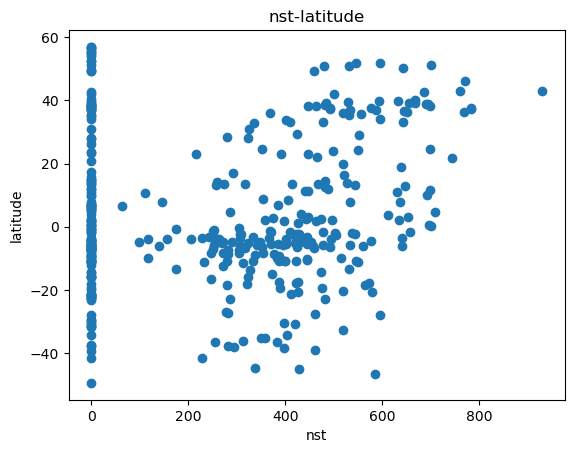

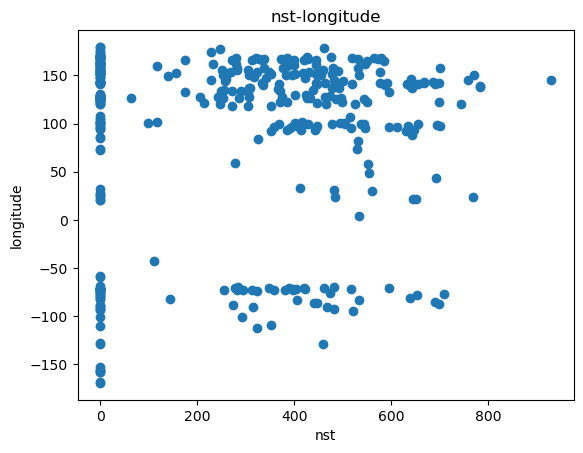

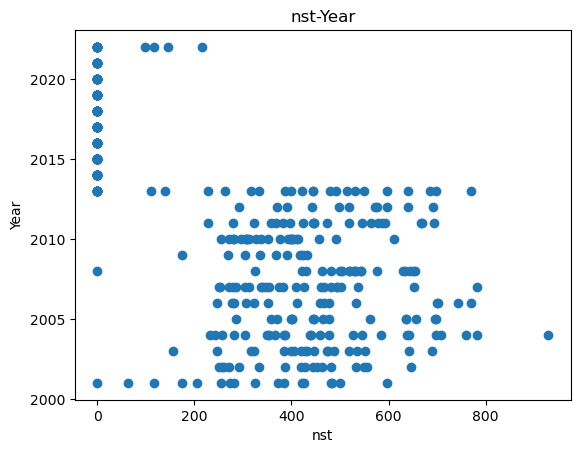

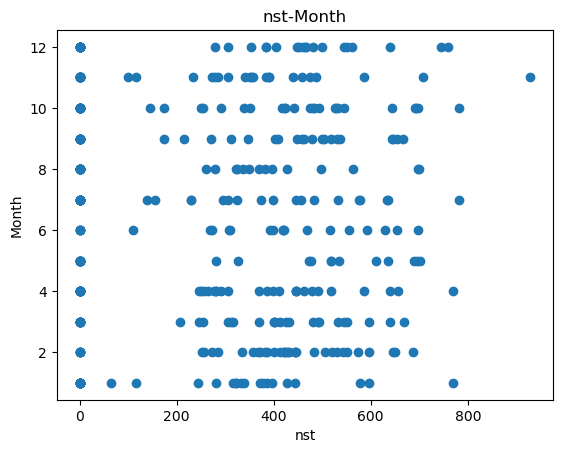

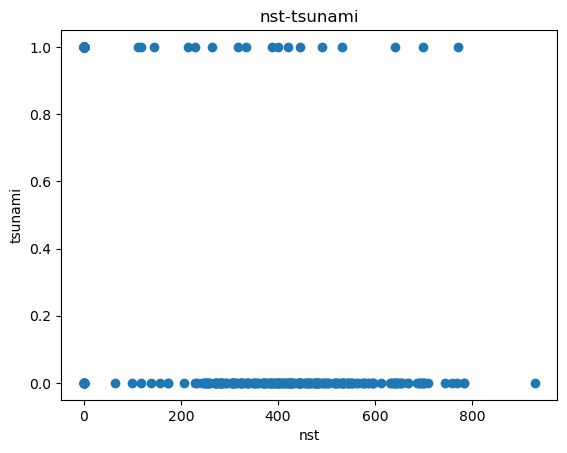

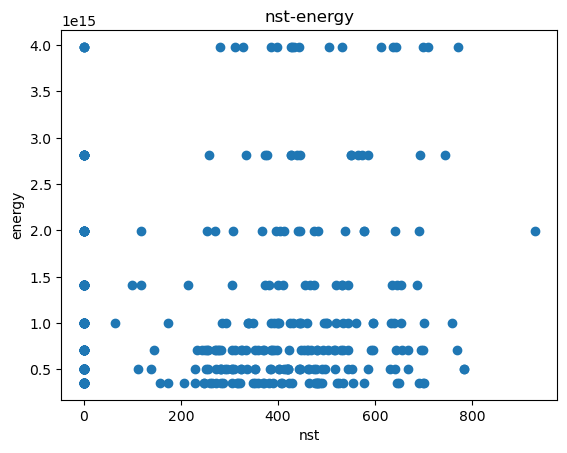

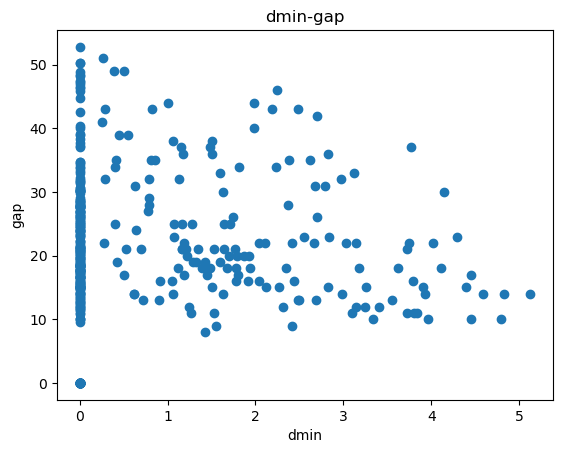

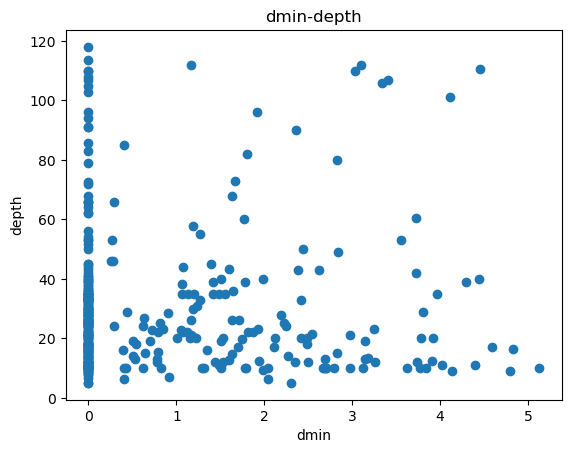

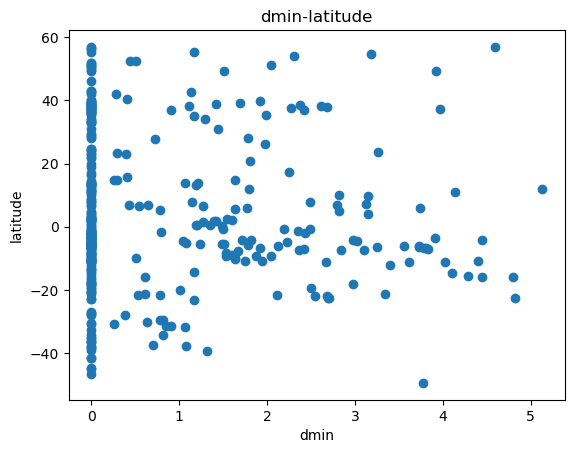

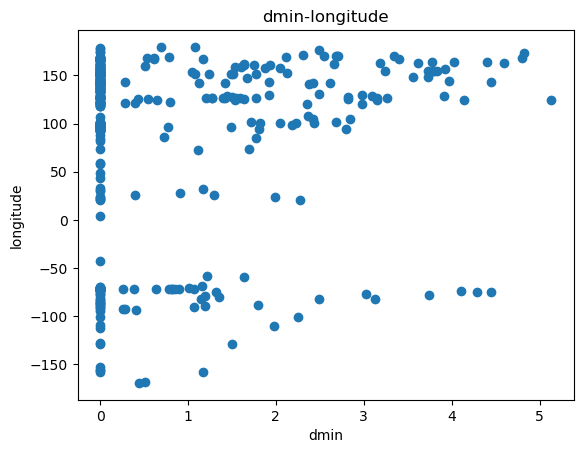

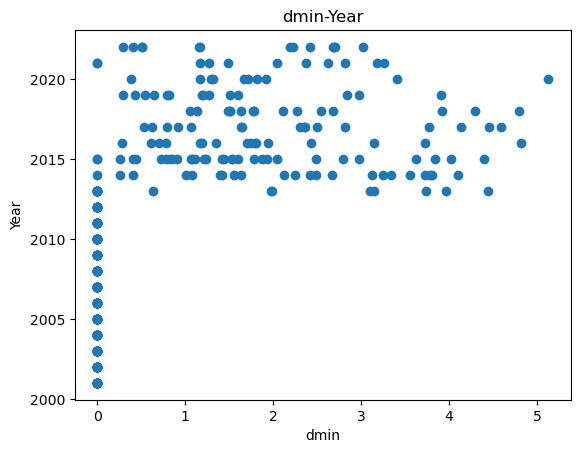

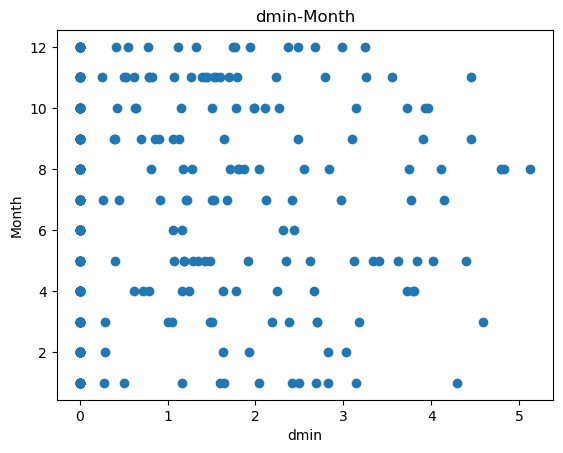

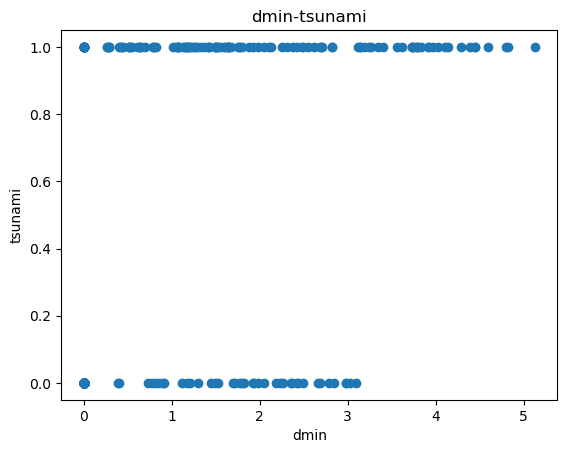

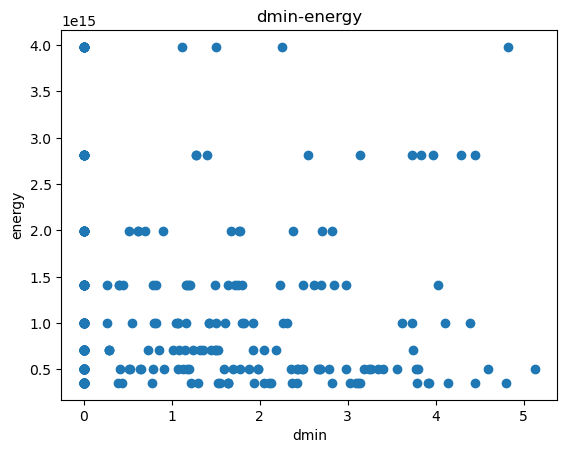

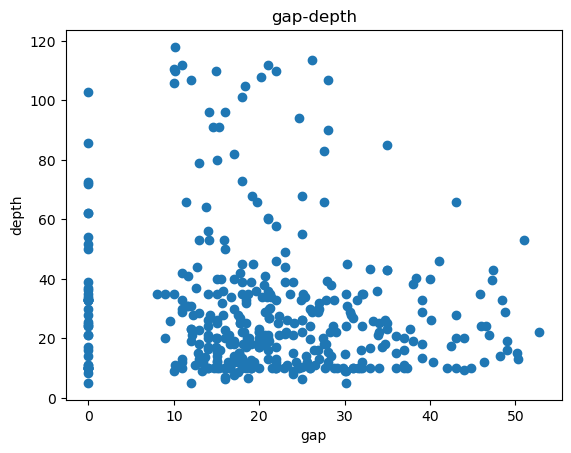

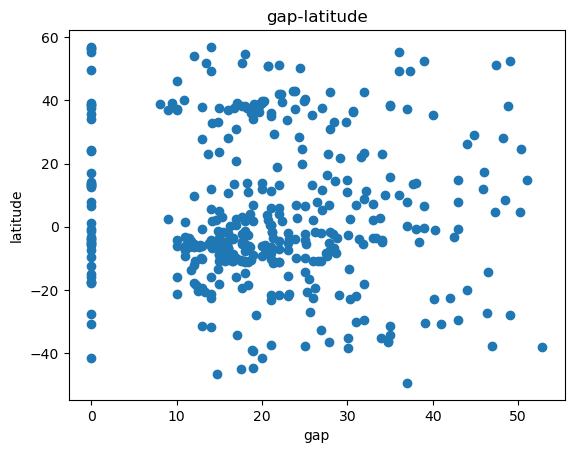

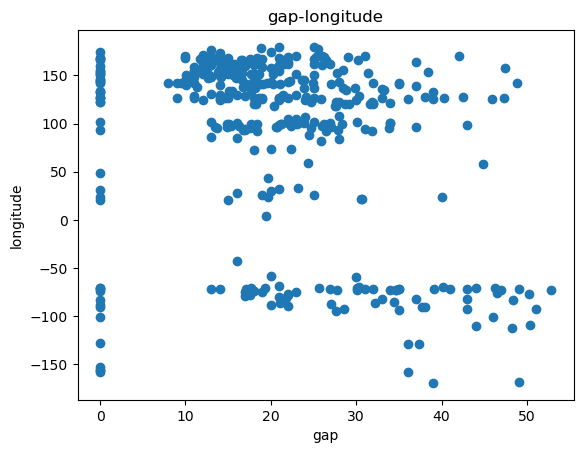

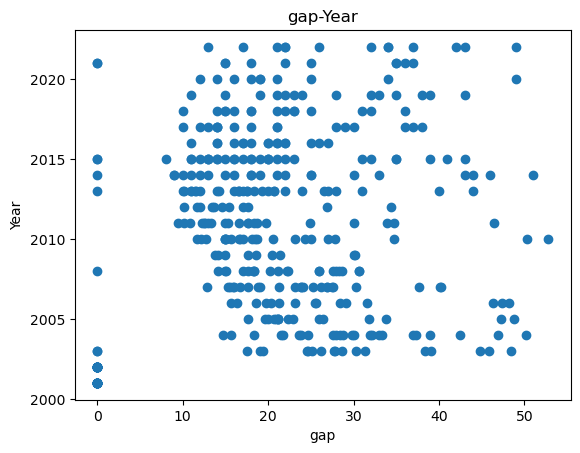

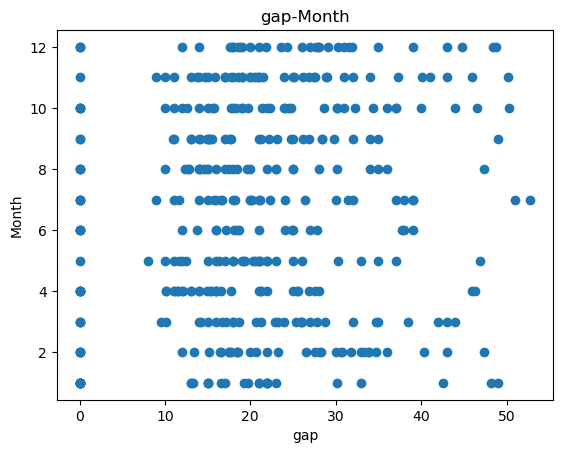

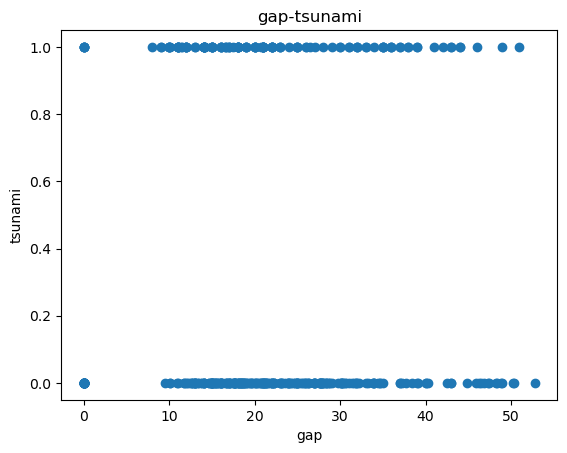

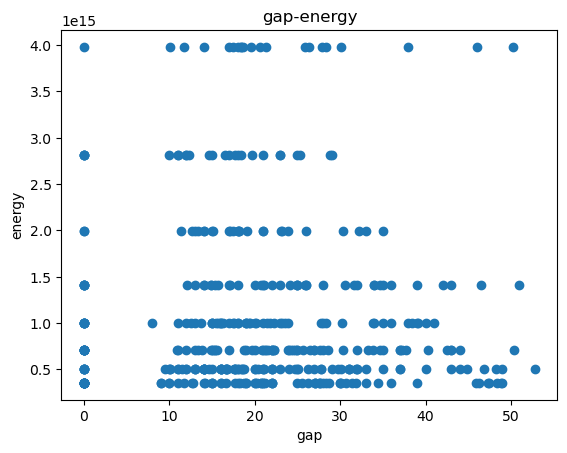

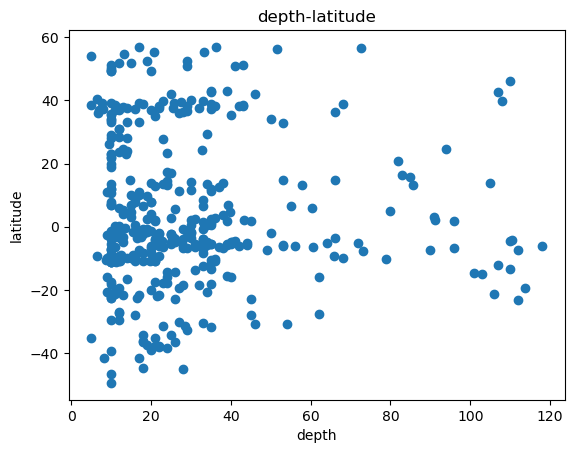

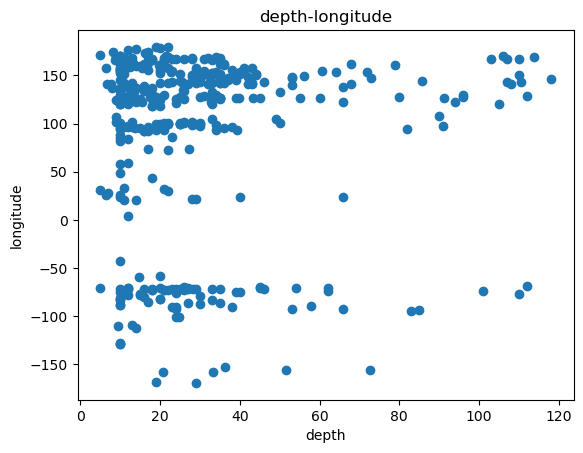

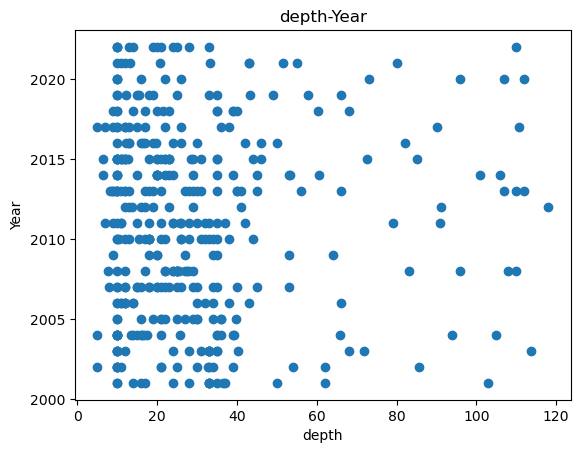

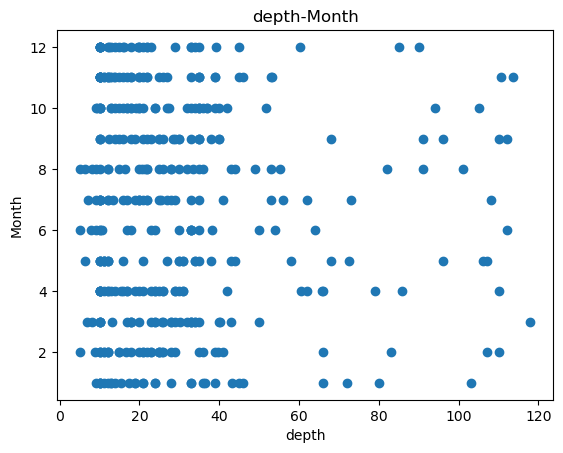

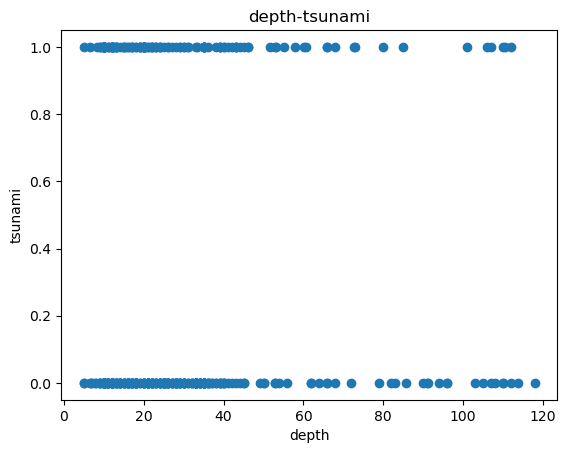

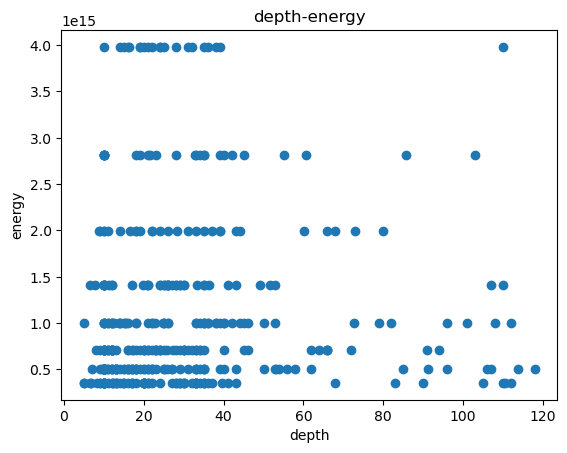

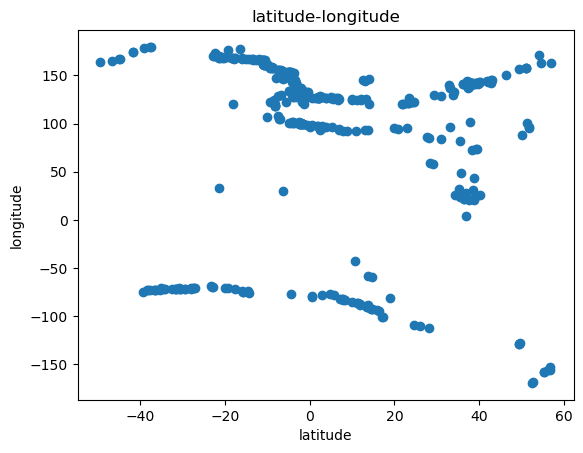

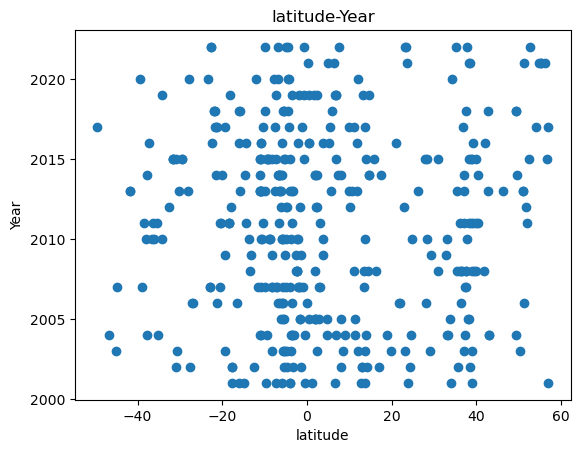

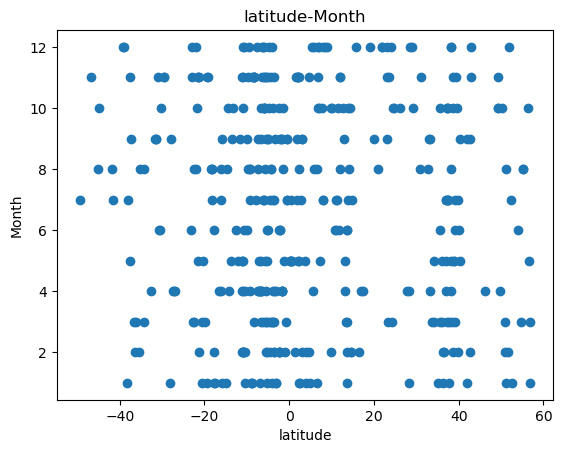

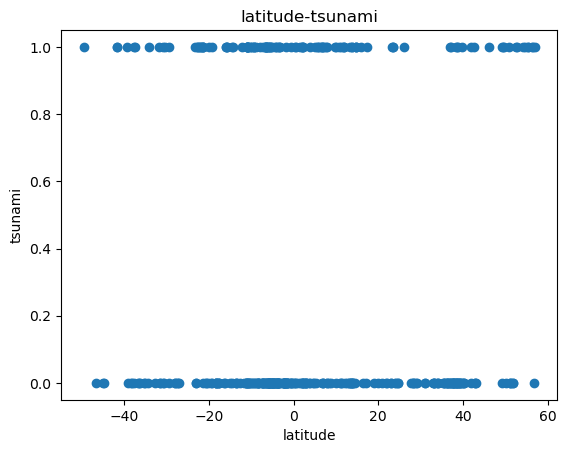

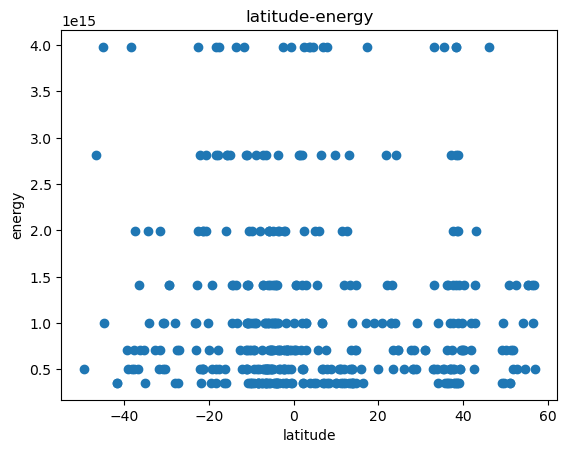

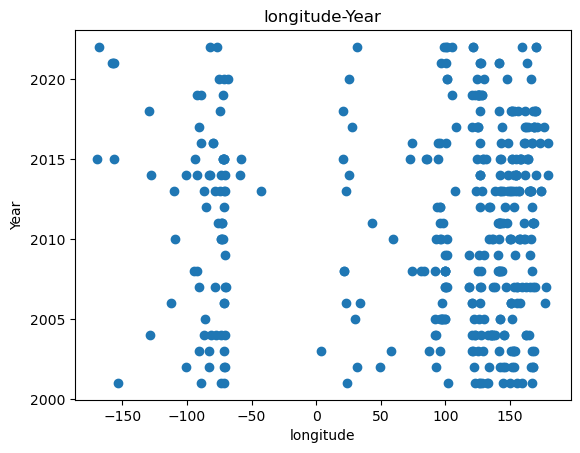

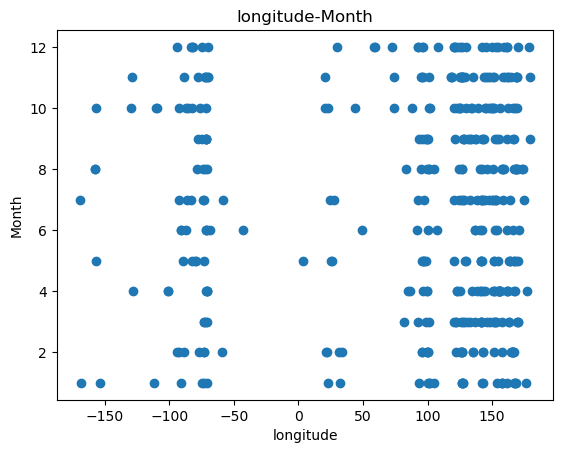

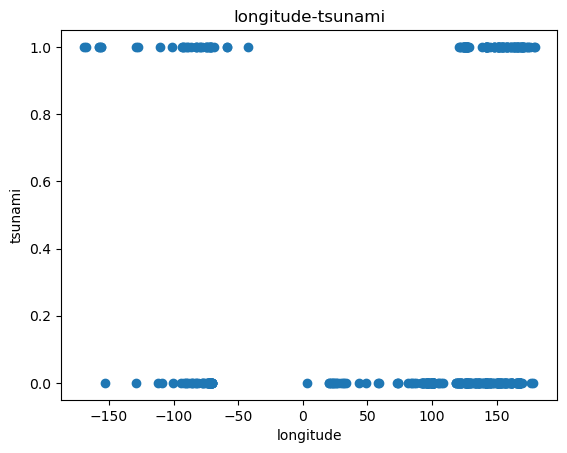

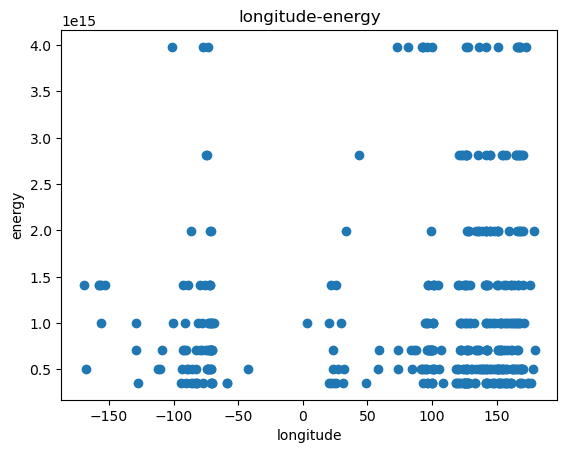

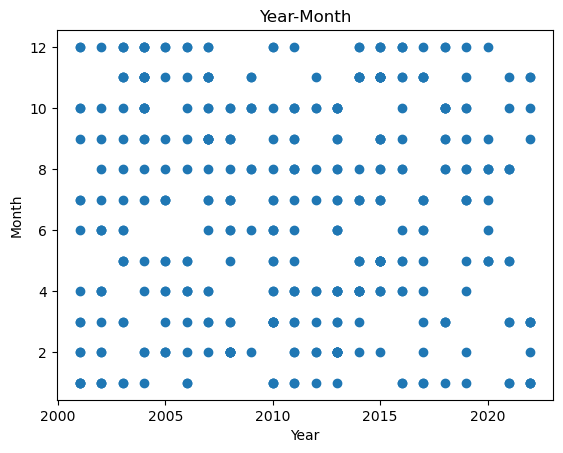

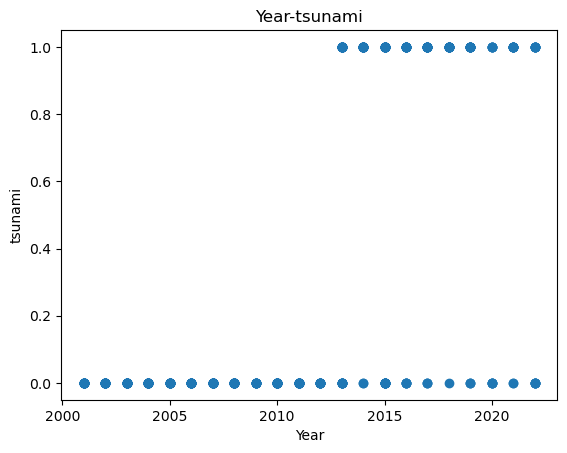

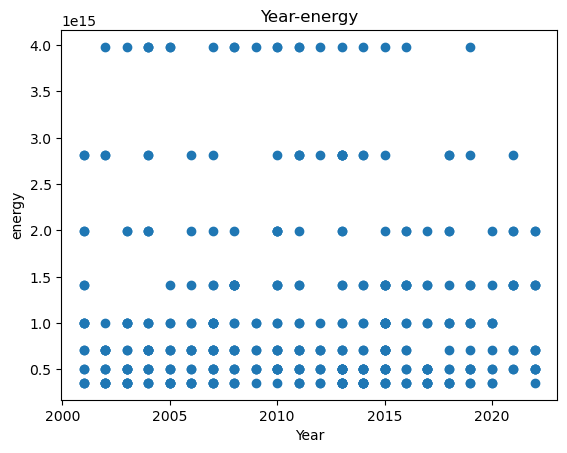

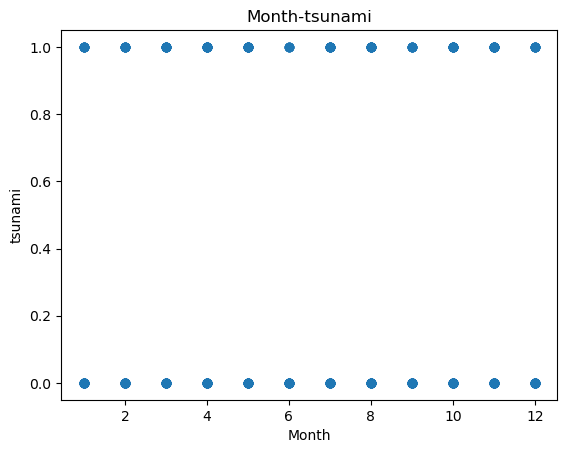

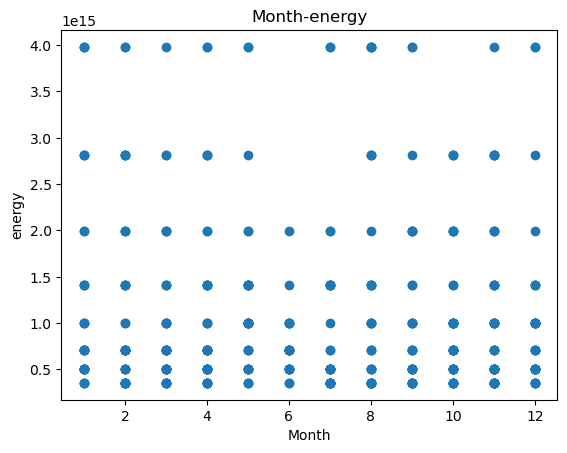

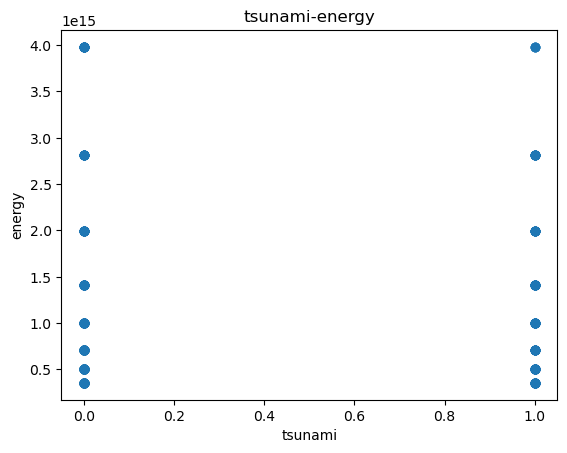

In [17]:
for i in range (len(df.columns)):
    for j in range(i+1, len(df.columns)):
        plt.scatter(df_clear[df.columns[i]], df_clear[df.columns[j]])
        plt.xlabel(df.columns[i])
        plt.ylabel(df.columns[j])
        plt.title(df.columns[i]+"-"+df.columns[j])
        plt.show()

Атрибуты magnitude, cdi, mmi, Year, Month, tsunami, energy не образуют видимых кластеров
dmin и gap образую множество кластеров с другими атрибутами, так как имеют большое количество нулевых значений
у longitude большинство значений находятся между 50-180 и (-100)-(-50), что также образует кластеры
longitude-latitude образуют кластеры, напоминающие своей формой карту земли, что и следовало ожидать
sig-nst, nst-depth, nst-latitude образую два кластера
nst-longitude образуют три кластера

Далее будем использовать метод KMeans для анализа кластеров

Для начала определим какое значение кластеров будем использовать через метод локтя

In [18]:
from sklearn.cluster import KMeans


In [19]:
wcss = []
for i in range(1, 9):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_clear)
    wcss.append(kmeans.inertia_)

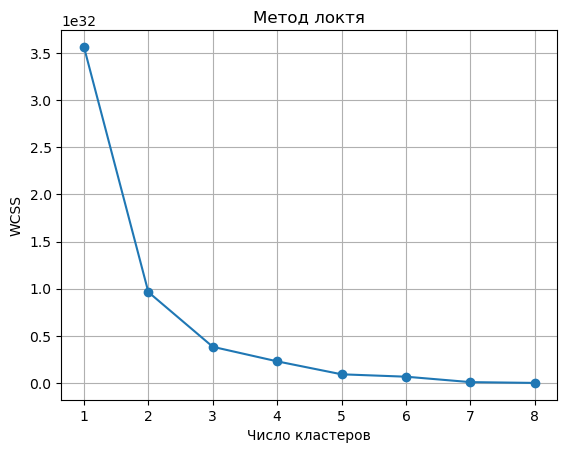

In [20]:
plt.plot(range(1, 9), wcss, marker='o')
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Смотря на график я беру значение кластеров равное 3

In [21]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_clear)

KMeans(n_clusters=3)

In [22]:
df_clear['cluster'] = kmeans.labels_

In [23]:
df_clear.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,energy,cluster
0,7.0,8,7,768,117,0.509,17.0,14.0,-9.7963,159.5960,2022,11,1,1.995262e+15,2
1,6.9,4,4,735,99,2.229,34.0,25.0,-4.9559,100.7380,2022,11,0,1.412538e+15,2
7,6.7,7,6,797,145,1.151,37.0,20.0,7.6712,-82.3396,2022,10,1,7.079458e+14,0
10,6.9,9,9,887,215,0.401,34.0,10.0,23.1444,121.3070,2022,9,1,1.412538e+15,2
22,7.0,6,4,763,0,2.705,26.0,10.0,-22.5732,170.3490,2022,3,1,1.995262e+15,2


Теперь мы ввидим новый атрибут, каждой из строк присвоен номер кластера

Далее посмотрим статистику кластеров

In [24]:
df_clear.groupby(['cluster']).mean()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,energy
cluster,,,,,,,,,,,,,,
0,6.636331,3.705036,6.032374,718.348921,260.320144,0.764705,21.184892,29.167230,4.213272,80.893900,2010.676259,6.748201,0.309353,6.092532e+14
1,7.200000,4.333333,6.285714,849.571429,406.380952,0.461571,22.766667,28.311905,3.236971,98.539033,2009.047619,6.047619,0.190476,3.981072e+15
2,6.981250,4.802083,6.177083,810.718750,251.010417,0.859177,19.676042,30.909375,3.890205,95.110758,2012.187500,6.302083,0.416667,1.948605e+15


Выводы: в этой работе я успешно добавил к датасету новый аттрибут, "причесал" его, нашел множество кластеров и объединил их в группы. В датасете оказалось не так много атрибутов, коррелирующих другс другом, а потому кластеры часто были связанны с особенностью распределения значений в отдельных атрибутах.